In [1]:
import gc
import json
from collections import Counter

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.api import CompareMeans, DescrStatsW

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

### Домашнее задание 2. Интерпретация результатов АБ-теста

Срок сдачи: 31 марта 18:00

На мобильной версии Авито провели тест на добавление рекламного баннера на карточку товара между описанием и блоком рекомендаций.

Продуктовая гипотеза:
Добавление рекламного баннера будет приводить к увелечинию выручки без ущерба пользовательскому опыт.

<div>
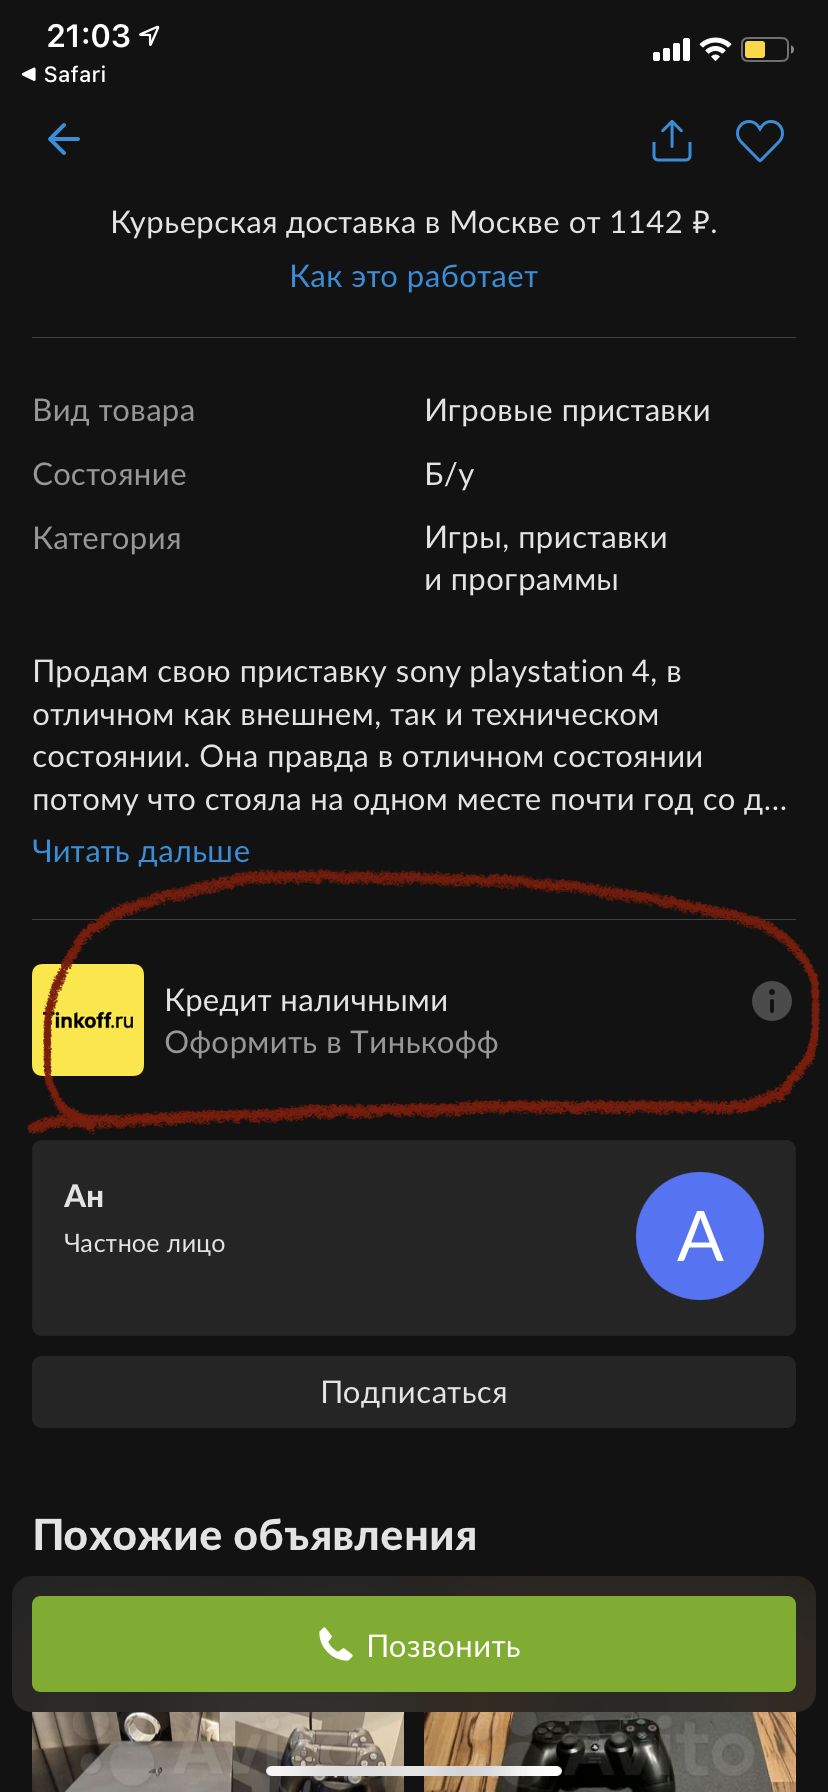
</div>

Задание:
1. Загрузите файл с данными, собранными за время аб теста.

2. На основе имеющихя в файле метрик формализуйте продуктовую гипотезу. Помимо количественных метрик рекомендую использовать ratio-метрики и метрики аггрегированные по пользователям(например, количество пользователей совершивших контакт) и при анализе теста обратите внимание на их чувтсвительность. (2 балла)

3.  Используя критерий Стьюдента, проинтерпретируйте как изменились средние выборок для выбранных вами метрик. Используйте уровень значимости 0.01.(2 балла)

4.  Выборка разделена на 200 бакетов. Примените к бакетам критерий Стьюдента и проинтерпретируйте как изменились средние выборок для выбранных вами метрик. Используйте уровень значимости 0.01. Сравните результаты с предыдущим пунктом. (2 балла)

6. Для анализа сформулированных в п.2 ratio-метрик воспольуйтесь Бутстрэпом. Являются ли эти метрики более чувствительными, чем базовые метрики? (2 балла)

7. Проинтерпретируйте результаты и сделайте выводы об изменениях для продукта. Рекомендуете ли вы изменение к запуску на 100% пользователей? (2 балла)

Формат данных

cookie_id - ид пользователя

split_group	- тестовая группа

searches - количество поисков

item_views - количество просмотров объявлений

contacts - количество контактов пользователя с продавцом	

rec_item_views - количество просмотров объявлений с рекомендацией

rec_contacts - контакты с рекомендацией

contact_cookie - пользователь, совершил контакт

advertising_clicks - клики на всю рекламу(Помимо добавленного баннера есть ещё баннеры в других местах. Эта метрика их учитывает.)

bucket - бакет

## Смотрим на данные

![](img/microwave-cropped.jpeg)

In [2]:
df = pd.read_csv('banner_test_results.csv')

NameError: name 'pd' is not defined

In [3]:
print(df.shape)
df.sample(5)

(1010805, 10)


,cookie_id,split_group,searches,item_views,contacts,rec_item_views,rec_contacts,contact_cookie,advertising_clicks,bucket
716309,3898087021185,test,5,14,0,3,0,0,0,185
238413,3288357301024,test,12,75,0,3,0,0,0,24
852368,3930839513812,test,0,32,0,0,0,0,0,12
148799,2714074550691,test,0,24,0,0,0,0,0,91
3261,274270813393,control,18,513,0,45,0,0,0,193


Наличие пропусков

In [18]:
df.isna().sum()

cookie_id             0
split_group           0
searches              0
item_views            0
contacts              0
rec_item_views        0
rec_contacts          0
contact_cookie        0
advertising_clicks    0
bucket                0
dtype: int64

Пропуски отсутствуют


Описание данных

In [32]:
df.describe().applymap(lambda x: round(x, 2))

,cookie_id,searches,item_views,contacts,rec_item_views,rec_contacts,contact_cookie,advertising_clicks,bucket
count,1.010805e+06,1010805.00,1010805.00,1010805.00,1010805.00,1010805.00,1010805.00,1010805.00,1010805.00
mean,3.374705e+12,94.55,682.62,11.73,28.15,0.27,0.15,0.36,99.45
std,8.433758e+11,1994.38,4140.41,341.67,190.38,3.86,0.36,5.65,57.76
min,5.898517e+09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.322187e+12,0.00,5.00,0.00,0.00,0.00,0.00,0.00,49.00
50%,3.730785e+12,0.00,22.00,0.00,0.00,0.00,0.00,0.00,99.00
75%,3.905482e+12,2.00,144.00,0.00,0.00,0.00,0.00,0.00,150.00
max,3.967647e+12,1431396.00,467968.00,133617.00,5000.00,176.00,1.00,661.00,199.00


Видим, что все наши метрики имеют сильно несимметричное распределение: медиана в нуле, а среднее порядка енскольких десятков или сотен


Нарисуем гистограмму для категориальных фичей

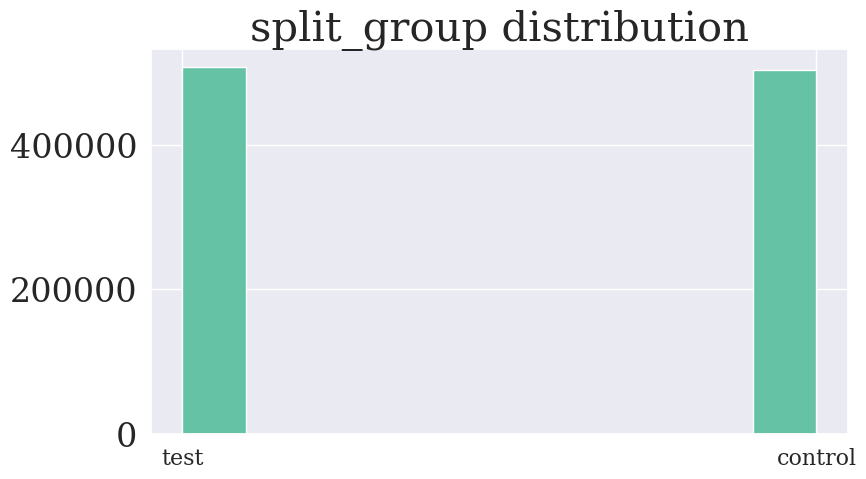

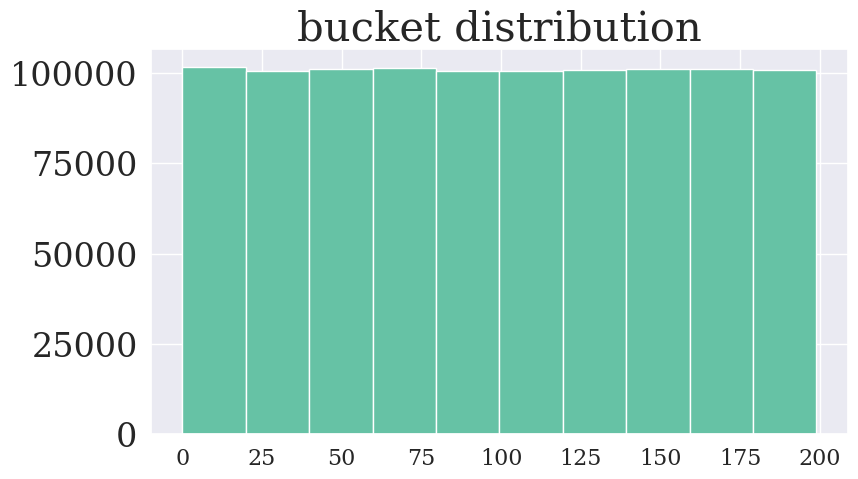

In [15]:
for col in ['split_group', 'bucket']:
    plt.figure(figsize=(9, 5))
    plt.hist(df[[col]].values)
    plt.title(f'{col} distribution')

Видим, что разбиение теста и контроля равно 50/50, по бакетам пользователи разбиты равномерно

Посмотрим на размер контроля и теста

In [183]:
Counter(df.split_group)

Counter({'test': 507422, 'control': 503383})

In [185]:
(507422 - 503383) / 503383 * 100

0.8023711567534064

## Что по метрикам, Карл?

В данном эксперименте все метрики можно разбить на 2 группы: метрики роста и метрики здоровья. Первые детектируют рост выручки (в данном случае это рост количества кликов на рекламу), а вторые проверяют, что мы ничего не поломали, и от нас не ушла значительная часть аудитории

1. Увеличение выручки  
- среднее число кликов на рекламу (по юзерам)
- общее число юзеров, переходящих по рекламе
- Additional: конверсия из просмотра в рекламный клик

2. Без ущерба UX  
- среднее число поисков (по юзерам)
- среднее число просмотров (по юзерам)
- среднее число контактов (по юзерам)
- общее число контактировавших юзеров
- Conversion Rate = $\dfrac{\sum\text{# contacts}}{\sum\text{# item_views}}$  
- Additional: конверсия рекомендаций из просмотра в контакт  

## Тесты Стьюдента, $\alpha$ = 0.01

In [94]:
ALPHA = 0.01
test, control = df[df.split_group == 'test'], df[df.split_group == 'control']

### Cреднее число кликов на рекламу

In [39]:
df.groupby('split_group')['advertising_clicks'].describe()

,count,mean,std,min,25%,50%,75%,max
split_group,,,,,,,,
control,503383.0,0.348071,5.520257,0.0,0.0,0.0,0.0,661.0
test,507422.0,0.379282,5.775738,0.0,0.0,0.0,0.0,614.0


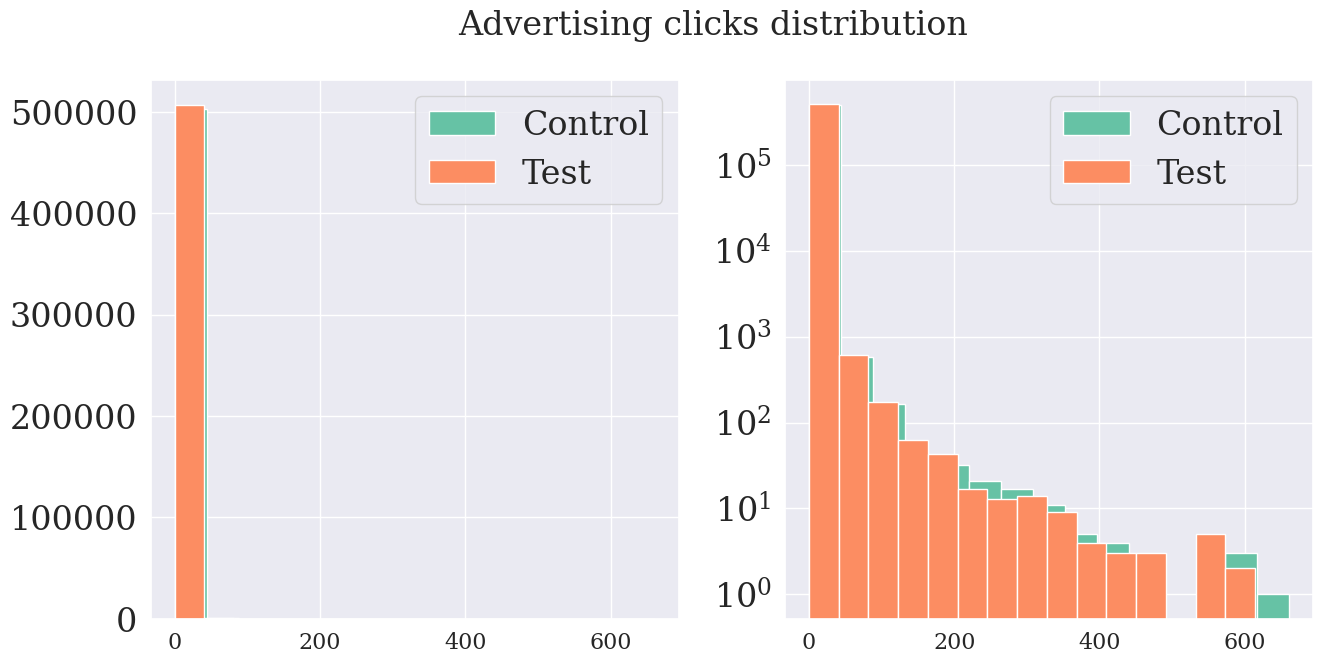

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].hist(control.advertising_clicks, bins=15, label='Control')
axes[0].hist(test.advertising_clicks, bins=15, label='Test')
axes[1].hist(control.advertising_clicks, bins=15, label='Control')
axes[1].hist(test.advertising_clicks, bins=15, label='Test')

axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
fig.suptitle('Advertising clicks distribution', fontsize=24)
plt.show()

In [41]:
stat, pval = stats.ttest_ind(
    control.advertising_clicks,
    test.advertising_clicks,
    equal_var=False,
    alternative='less'
)
print(f'{stat =}, {pval = }')

stat =-2.7774193092517643, pval = 0.002739672676259143


Смотрим на 99% ДИ

In [148]:
cm = CompareMeans(DescrStatsW(control.advertising_clicks), DescrStatsW(test.advertising_clicks))
print(cm.tconfint_diff(alpha=ALPHA, alternative='smaller', usevar='unequal'))

(-inf, -0.005068831102124454)


**Вывод:**  
Нулевая гипотеза отвергается, эффект детектируется  
Видим рост числа рекламных переходов в среднем на 1 юзера на 0.005 кликов, и это как минимум

**Cреднее число поисков**

In [42]:
df.groupby('split_group')['searches'].describe()

,count,mean,std,min,25%,50%,75%,max
split_group,,,,,,,,
control,503383.0,92.857278,1382.604010,0.0,0.0,0.0,3.0,357442.0
test,507422.0,96.238405,2455.009497,0.0,0.0,0.0,2.0,1431396.0


In [44]:
stat, pval = stats.ttest_ind(
    control.searches,
    test.searches,
    equal_var=True,
    alternative='two-sided'
)
print(f'{stat =}, {pval = }')

stat =-0.8522238162318566, pval = 0.3940900823629334


**Cреднее число просмотров**

In [45]:
df.groupby('split_group')['item_views'].describe()

,count,mean,std,min,25%,50%,75%,max
split_group,,,,,,,,
control,503383.0,680.449985,4082.018002,0.0,5.0,23.0,145.0,467968.0
test,507422.0,684.772795,4197.532575,0.0,5.0,22.0,144.0,375972.0


In [46]:
stat, pval = stats.ttest_ind(
    control.item_views,
    test.item_views,
    equal_var=True,
    alternative='two-sided'
)
print(f'{stat =}, {pval = }')

stat =-0.52483532880938, pval = 0.5996977848883321


**Cреднее число контактов**

In [47]:
df.groupby('split_group')['contacts'].describe()

,count,mean,std,min,25%,50%,75%,max
split_group,,,,,,,,
control,503383.0,11.020771,302.264175,0.0,0.0,0.0,0.0,93636.0
test,507422.0,12.428397,376.709140,0.0,0.0,0.0,0.0,133617.0


In [50]:
stat, pval = stats.ttest_ind(
    control.contacts,
    test.contacts,
    equal_var=True,
    alternative='two-sided'
)
print(f'{stat =}, {pval = }')

stat =-2.071008010953326, pval = 0.038358300597450816


**Вывод:**  
Нулевые гипотезы не отвергаются, ничего не ломается

## t-тест на бакетах

Создаём бакеты

In [67]:
control_buckets = control.groupby('bucket')
test_buckets = test.groupby('bucket')

Смотрим на средний размер бакета в тесте и в контроле

In [136]:
print('Control:\n', control_buckets.cookie_id.count().describe(), sep='')
print('Test:\n', test_buckets.cookie_id.count().describe(), sep='')

Control:
count     200.000000
mean     2516.915000
std        52.462456
min      2394.000000
25%      2479.000000
50%      2515.500000
75%      2548.250000
max      2690.000000
Name: cookie_id, dtype: float64
Test:
count     200.00000
mean     2537.11000
std        53.61015
min      2434.00000
25%      2494.00000
50%      2533.50000
75%      2573.00000
max      2747.00000
Name: cookie_id, dtype: float64


Грубо говоря, в среднем 1 бакет содержит 2520 юзеров

Визуализируем клики по бакетам

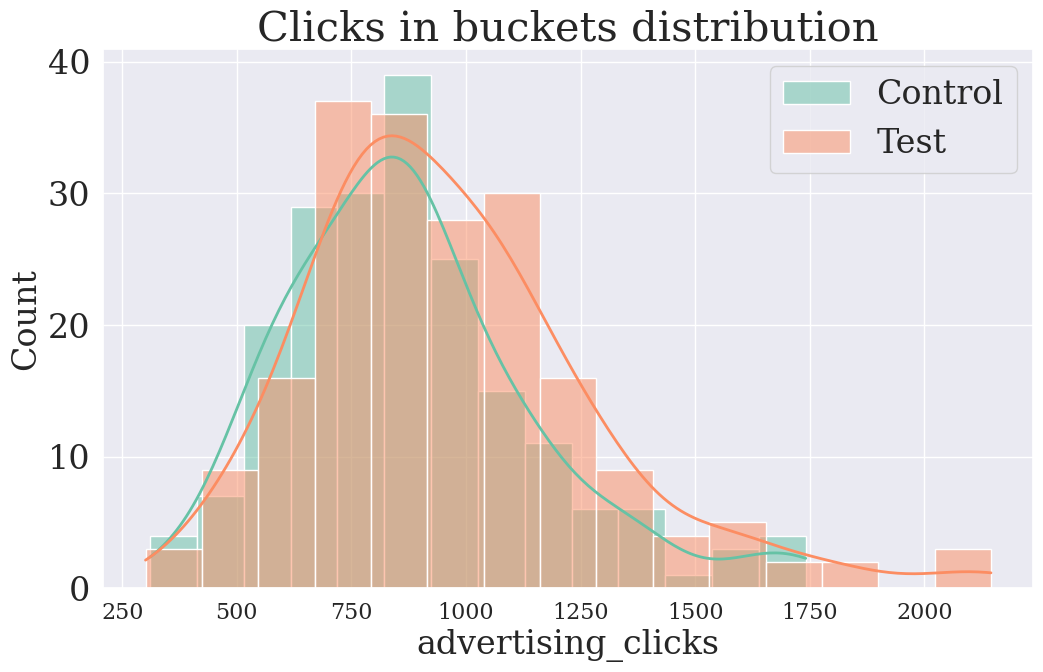

In [73]:
sns.histplot(control_buckets.advertising_clicks.sum(), kde=True, label='Control')
sns.histplot(test_buckets.advertising_clicks.sum(), kde=True, label='Test')

plt.title('Clicks in buckets distribution')
plt.legend()
plt.show()

### Cреднее число кликов на рекламу

In [74]:
stat, pval = stats.ttest_ind(
    control_buckets.advertising_clicks.sum(),
    test_buckets.advertising_clicks.sum(),
    equal_var=False,
    alternative='less'
)
print(f'{stat =}, {pval = }')

stat =-2.9034744973541575, pval = 0.0019500073097196663


Смотрим на 99%-ДИ

In [151]:
cm = CompareMeans(
    DescrStatsW(control_buckets.advertising_clicks.sum()),
    DescrStatsW(test_buckets.advertising_clicks.sum())
)
print(cm.tconfint_diff(alpha=ALPHA, alternative='smaller', usevar='unequal'))

(-inf, -16.85233018181445)


**Вывод:**  
Нулевая гипотеза отвергается, эффект детектируется  
При этом pvalue стало меньше, чем в t-тесте на юзерах (было 0.0027, стало 0.00195).  
Таким образом, t-тест на бакетах оказался более чувствительным. Это и неудивительно, поскольку дисперсия новой у.е. стала меньше.  

Видим рост числа рекламных переходов в среднем на $\approx$ 2520 юзеров на 16.8 кликов как минимум, или же на 0.0067 кликов на 1 юзера.  
А напомню, что ранее оценённый миним.эффект равнялся 0.005 кликов на 1 юзера

**Cреднее число поисков**

In [75]:
stat, pval = stats.ttest_ind(
    control_buckets.searches.sum(),
    test_buckets.searches.sum(),
    equal_var=False,
    alternative='two-sided'
)
print(f'{stat =}, {pval = }')

stat =-1.0175734055404915, pval = 0.15484529219694418


**Cреднее число просмотров**

In [76]:
stat, pval = stats.ttest_ind(
    control_buckets.item_views.sum(),
    test_buckets.item_views.sum(),
    equal_var=False,
    alternative='two-sided'
)
print(f'{stat =}, {pval = }')

stat =-1.1061183547530267, pval = 0.13467285613071003


**Cреднее число контактов**

In [77]:
stat, pval = stats.ttest_ind(
    control_buckets.contacts.sum(),
    test_buckets.contacts.sum(),
    equal_var=False,
    alternative='two-sided'
)
print(f'{stat =}, {pval = }')

stat =-2.275720077316274, pval = 0.011707909732657036


Смотрим на 98%-ный ДИ

In [189]:
cm = CompareMeans(
    DescrStatsW(control_buckets.contacts.sum()),
    DescrStatsW(test_buckets.contacts.sum())
)
print(cm.tconfint_diff(alpha=0.02, alternative='smaller', usevar='unequal'))

(-inf, -358.3189340580184)


In [190]:
358 / 2520

0.14206349206349206

**Вывод:**  
Нулевые гипотезы по-прежнему не отвергаются, ничего не ломается.  
Однако pvalue стали значительно ниже.

## Глянем на t-тест для ConversionRate по бакетам

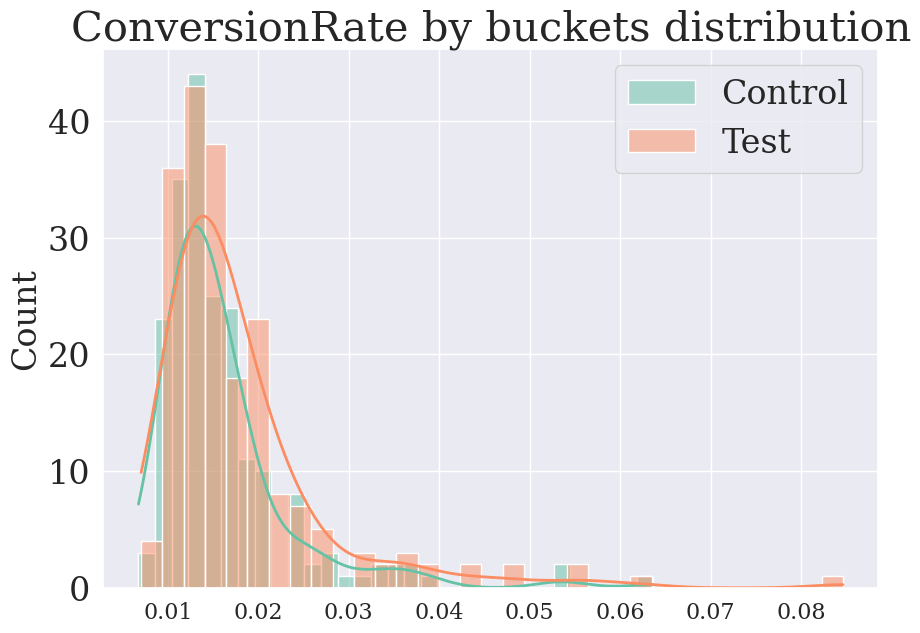

In [161]:
control_cr = control_buckets['contacts'].sum() / control_buckets['item_views'].sum()
test_cr = test_buckets['contacts'].sum() / test_buckets['item_views'].sum()

plt.figure(figsize=(10, 7))
sns.histplot(control_cr, kde=True, label='Control')
sns.histplot(test_cr, kde=True, label='Test')

plt.title('ConversionRate by buckets distribution')
plt.legend()
plt.show()

In [158]:
stat, pval = stats.ttest_ind(
    control_cr,
    test_cr,
    equal_var=True,
    alternative='less'
)
print(f'{stat =}, {pval = }')

stat =-2.135531977479579, pval = 0.016663723722084155


**Вывод:**  
Conversion Rate у теста и контроля отличается несильно на уровне значимости в 1%

## Бутстрап для ratio-метрик

Conversion Rate на тесте и на контроле

In [81]:
print('Control Conversion Rate:', control['contacts'].sum() / control['item_views'].sum())
print('Test Conversion Rate:', test['contacts'].sum() / test['item_views'].sum())

Control Conversion Rate: 0.016196299062069437
Test Conversion Rate: 0.018149665077392952


Функция для дальнейшей эксплуатации в процедуре бутстрапа

In [87]:
def conversion_rate(sample1: np.ndarray, sample2: np.ndarray) -> float:
    '''
    sample1.shape = (n, 2)
    sample2.shape = (n, 2)
    
    
    Sample Structure = [
        contacts_info.T <-- (n, 1),
        item_views_info.T <-- (n, 1)
    ]
    '''
    return sum(sample1[:, 0]) / sum(sample1[:, 1]) - sum(sample2[:, 0]) / sum(sample2[:, 1])

Смотрим на значение дельты конверсии на наших данных

In [112]:
contacts_and_views_control = control[['contacts', 'item_views']].values
contacts_and_views_test = test[['contacts', 'item_views']].values

conversion_rate(contacts_and_views_control, contacts_and_views_test)

-0.001953366015323515

Собираем статистики с помощью бутстрапа

In [105]:
bs_stats = []
BS_RESAMPLES = 5000
np.random.seed(SEED)

for _ in tqdm(range(BS_RESAMPLES)):
    control_indices = np.random.randint(0, len(control), len(control))
    test_indices = np.random.randint(0, len(test), len(test))
    
    control_sample = contacts_and_views_control[control_indices]
    test_sample = contacts_and_views_test[test_indices]
    
    stat = conversion_rate(control_sample, test_sample)
    bs_stats.append(stat)
    
    gc.collect()

  0%|          | 0/5000 [00:00<?, ?it/s]

Смотрим на гистограмку

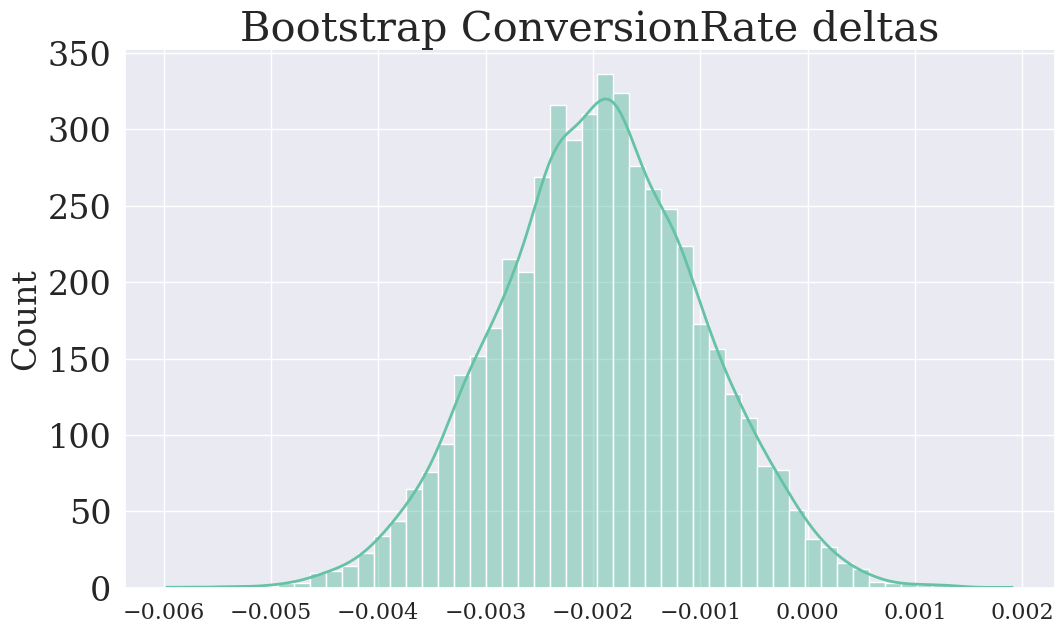

In [114]:
sns.histplot(bs_stats, kde=True)
plt.title('Bootstrap ConversionRate deltas')
plt.show()

Смотрим на перцентильный 99%-ный дов.интервал

In [179]:
def build_ci(stats: list, alpha: float) -> tuple:
    return (
        -np.inf,
        np.quantile(bs_stats, 1-alpha)
    )


print(f'99%-ный ДИ:', build_ci(bs_stats, ALPHA))
print(f'98.5%-ный ДИ:', build_ci(bs_stats, 0.015))
print(f'98%-ный ДИ:', build_ci(bs_stats, 0.02))
print(f'95%-ный ДИ:', build_ci(bs_stats, 0.05))

99%-ный ДИ: (-inf, 0.0002335405735855233)
98.5%-ный ДИ: (-inf, 9.578406685938461e-05)
98%-ный ДИ: (-inf, -9.241987950626649e-06)
95%-ный ДИ: (-inf, -0.0003578799952415294)


**Вывод:**  
Бутстрап критерий к RATIO-метрике обладает примерно той же чувствительностью, что и t-тест на бакетах по CR: у бутстрапа pvalue между 1.5% и 2%, у ttest-а pvalue = 1.67%

## Count metrics  

<u>Замечание:</u>  
Наблюдаемый количественный эффект слегка завышен, поскольку размер тестовой выборки больше размера контрольной выборки на 4 тысячи человек (на 0.8%)

**Общее число юзеров, переходящих по рекламе**

In [139]:
print('Control:', (control.advertising_clicks > 0).sum())
print('Test:', (test.advertising_clicks > 0).sum())

Control: 7992
Test: 8369


In [180]:
(8369 - 7992) / 7992 * 100

4.717217217217217

Видим рост на 4.7% (на 370 человек)

**Общее число контактировавших юзеров**

In [140]:
print('Control:', control.contact_cookie.sum())
print('Test:', test.contact_cookie.sum())

Control: 73502
Test: 79608


In [181]:
(79608 - 73502) / 73502 * 100

8.307256945389241

Видим рост на 8.3% (на 6000 контактов)

## Вывод

Число рекламных переходов увеличилось как минимум на 0.0067 кликов на 1 юзера (на 33.5 тысяч кликов).  

При этом остальные метрики не пострадали.  
Более того, при уровне значимости в 2% виден незначительный рост числа контактов -- 0.142 контакта на 1 человека.  

**Итог:** Данное изменение рекомендовано к выкату в прод